In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import codecs
import re
import time
import random
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from fake_useragent import UserAgent
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


Первым этапом будет создание корпуса русскоязычных текстов. 
Для этого проведем пасинг сервиса allhockey.ru, раздела КХЛ.

In [2]:
url = 'https://allhockey.ru/'
page = requests.get(url)
time.sleep(1)
page

<Response [200]>

Первым этапом соберем ссылки на страницы сайта, где расположены статьи:

In [3]:
pages = []
for i in range(0, 1000, 20):
    pages.append('https://allhockey.ru/article/khl?offset=0' + str(i) + '&max=20'+'.html')
    time.sleep(1)
print (pages[0:10])

['https://allhockey.ru/article/khl?offset=00&max=20.html', 'https://allhockey.ru/article/khl?offset=020&max=20.html', 'https://allhockey.ru/article/khl?offset=040&max=20.html', 'https://allhockey.ru/article/khl?offset=060&max=20.html', 'https://allhockey.ru/article/khl?offset=080&max=20.html', 'https://allhockey.ru/article/khl?offset=0100&max=20.html', 'https://allhockey.ru/article/khl?offset=0120&max=20.html', 'https://allhockey.ru/article/khl?offset=0140&max=20.html', 'https://allhockey.ru/article/khl?offset=0160&max=20.html', 'https://allhockey.ru/article/khl?offset=0180&max=20.html']


In [7]:
print (len(pages))


50


Получился список с ссылками на 50 страниц. 

Теперь соберем ссылки на статьи в новый список:

In [8]:
all_articles=[]


for page in pages:
    all_links = requests.get(page)
    soup = BeautifulSoup(all_links.text, features="html.parser")
    content=soup.find_all('div', {'class': 'content'})
    for i in content:
        articles=i.find_all('a')
        for article in articles:
            href = article.get('href')  
            if href.startswith('/article/show') and '#comments' not in href:  
                all_articles.append ('https://allhockey.ru/' + href)
                time.sleep(1)
  

In [9]:
print (len(all_articles))  


1000


Получился список из 1000 статей.

Теперь нужно собрать тексты самих статей.

In [2]:
texts = []
fails=[]
for article in all_articles:
    try:
        links = requests.get(article)
        soup1 = BeautifulSoup(links.text, features="html.parser")
        for i in soup1.find_all('div', {'class' : "ui grid material-content"}):
            text=i.find('div', {'itemprop': 'articleBody'})
            text=text.text.strip()
            texts.append(text)
        time.sleep(6)
    except :
        fails.append(article)    
                
print (len(texts))
print (len(fails))    

 

NameError: name 'all_articles' is not defined

Все 1000 текстов успешно собраны в список. Теперь нужно сохранить его в файл для дальнейшей работы без потери собранных данных.

In [11]:
with open("khl_articles.txt", "w", encoding="utf-8") as file:
    for text in texts:
        file.write(text + "\n")

Теперь соберем данные с англоязычных ресурсов. 

In [2]:
url = 'https://www.nbcsports.com/nhl'
response = requests.get(url)
time.sleep(1)
print(response.status_code)


200


Так как сайт с динамической выдачей, и новые страницы открываются при помощи нажатия кнопки внизу страницы, потребуется несколько иной подход.

Будем использовать selenium, чтобы открыть необходимое количество страниц и собрать с них нужные данные.

In [2]:
xpath='//*[@id="Page-content"]/main/div[3]/bsp-load-more/button'
driver_path='C:\\Users\\Алия\\Desktop\\учеба\\проект\\chromedriver.exe'

In [ ]:
driver = webdriver.Chrome()

try:
    driver.get(url)
    time.sleep(2)
    for i in range(5):#на сайте доступно открытие только пяти страниц со статьями (проверено в ручном режиме)
        try:
            button = driver.find_element(By.XPATH, xpath)
            actions=ActionChains(driver)
            actions.move_to_element(button).perform()
            time.sleep(3)
            button.click()
            time.sleep(5)
        except Exception as e:
            print(f"Ошибка {i + 1}: {e}")
            break    
    with open("pages_nhl.html", "w", encoding="utf-8") as file:
        file.write(driver.page_source)      
    
finally:
    driver.close()
    driver.quit()       

Сохрним файл html для дальнейшей работы.

In [8]:
f = codecs.open("pages_nhl.html", 'r', 'utf-8') # читаем код html из файла
pages_nhl = f.read() # записываем его в переменную
f.close()
soup = BeautifulSoup(pages_nhl)

Следующим шагом соберем ссылки на статьи.

In [9]:
links=[]
for i in soup.find_all('a', {'class' : "Link"}):
    link=i.get('href')
    if link.startswith('https://www.nbcsports.com/nhl/news/'):
        links.append(link)
links=set(links)    

In [10]:
print (len(links))

55


Для обработки доступно 55 статей. Относительно собранного корпуса русскоязычных статей, это очень маленькое количество, поэтому заменим сайт на другой. Загруженные данные оставим на случай, если в них появится необходимость. Проделаем аналогичные действия.

In [22]:
url = 'https://www.nytimes.com/athletic/nhl/'
response = requests.get(url)
time.sleep(1)
print(response.status_code)

200


In [ ]:
driver = webdriver.Chrome()

try:
    driver.get(url)
    time.sleep(2)
    for i in range(100):
        try:
            button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//p[contains(text(), 'See More')]")))
            actions=ActionChains(driver)
            actions.move_to_element(button).perform()
            time.sleep(random.uniform(3, 7))
            button.click()
            time.sleep(random.uniform(5, 7))
        except Exception as e:
            print(f"Ошибка {i + 1}: {e}")
            break    
    with open("pages_nhl_nytimes.html", "w", encoding="utf-8") as file:
        file.write(driver.page_source)      
    
finally:
    driver.close()
    driver.quit()  

In [2]:
f = codecs.open("pages_nhl_nytimes.html", 'r', 'utf-8') # читаем код html из файла
pages_nhl_nytimes = f.read() # записываем его в переменную
f.close()
soup = BeautifulSoup(pages_nhl_nytimes)

In [3]:
links_nhl=[]
for i in soup.find_all('a'):
    link=i.get('href')
    if link:  # Проверяем, что ссылка не None
        href = re.search(r'https://www\.nytimes\.com/athletic/\d+.+', link)  # Ищем только нужные ссылки
        if href:  # Если нашли совпадение
            links_nhl.append(href.group())


In [5]:
print(len(links_nhl))

999


Следущий шаг - сбор ссылок на статьи.

In [10]:
texts_nhl=[]
fails=[]
for link in links_nhl:
    try:
        article=requests.get(link)
        soup=BeautifulSoup(article.text, features="html.parser")
        for i in soup.find_all('div', {'class' : "sc-f17269a7-9 enmElg article-content-container bodytext1"}):
            paragraphs = i.find_all('p')
            article_text = "\n".join(p.text.strip() for p in paragraphs if p.text.strip()) 
            texts_nhl.append(article_text)
        time.sleep(random.uniform(1,5))
    except Exception as e:
        print(f"ошибка {link}: {e}")
        fails.append(link)  

print (f'Количество текстов: {len(texts_nhl)}')
print (f'Статьи с ошибками:{len(fails)}')


ошибка https://www.nytimes.com/athletic/5901047/2024/11/06/nhl-worst-team-hockey-hall-of-fame/: HTTPSConnectionPool(host='www.nytimes.com', port=443): Max retries exceeded with url: /athletic/5901047/2024/11/06/nhl-worst-team-hockey-hall-of-fame/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021EE6DBEE90>: Failed to resolve 'www.nytimes.com' ([Errno 11001] getaddrinfo failed)"))
Количество текстов: 985
Статьи с ошибками:1


In [11]:
with open("nhl_articles_nytimes.txt", "w", encoding="utf-8") as file:
    for text in texts_nhl:
        file.write(text + "\n")

На этапе сбора данных получилось:
1) 1000 текстов на русском языке
2) 985 текстов на английском языке (количество текстов отличается с количесвтом ссылок, так как некоторые ссылки содержат видеоконтент)

Чтобы уравновесить количество текстов, можно вернуться к собранным ранее ссылкам на статьи с NBCsports, и выгрузить необходимую разницу оттуда.
И также обработаем 1 статью, вошедшую в список fails.


In [ ]:
#обработка статьи, вошедшей в список fails
link='https://www.nytimes.com/athletic/5901047/2024/11/06/nhl-worst-team-hockey-hall-of-fame/'
article=requests.get(link)
soup=BeautifulSoup(article.text, features="html.parser")
for i in soup.find_all('div', {'class' : "sc-f17269a7-9 enmElg article-content-container bodytext1"}):
    paragraphs = i.find_all('p')
    article_text = "\n".join(p.text.strip() for p in paragraphs if p.text.strip()) 



In [4]:
#добавляем текст статьи в файл с остальными текстами
with open("nhl_articles_nytimes.txt", "a", encoding="utf-8") as file:
    file.write("\n" + article_text)

In [ ]:
#обработка собранных статей с nbc.news
texts_nbc=[]

for link in links:
    try:
        article=requests.get(link)
        soup=BeautifulSoup(article.text, features="html.parser")
        for i in soup.find_all('div', {'class' : "RichTextArticleBody RichTextBody"}):
            paragraphs_nbc = i.find_all('p')
            article = "\n".join(p.text.strip() for p in paragraphs_nbc if p.text.strip()) 
            texts_nbc.append(article)
        time.sleep(random.uniform(1,5))
    except Exception as e:
        print(f"ошибка {link}: {e}")
            
print (f'Количество текстов: {len(texts_nbc)}')


Количество текстов: 55


In [15]:
#добавим еще 14 текстов в наш корпус
with open("nhl_articles_nytimes.txt", "a", encoding="utf-8") as file:
    for text in texts_nbc[0:13]:
        file.write("\n" + text)

Теперь, когда тектсы для обработки собраны, можно приступить к их обработке. Начну также с русскоязычного корпуса.
 

In [2]:
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from pymystem3 import Mystem
from nltk.util import ngrams
morph = Mystem()
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Алия\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Алия\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Алия\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Алия\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Алия\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
with open("khl_articles_summer.jsonl", "r", encoding='utf-8') as f:
    text = f.read()

In [5]:
stop_words = stopwords.words('russian')

In [7]:
text=text.lower()
tokens = word_tokenize(text) #делим на токены
text_without_punkt = [word for word in tokens if word[0].isalpha()]
tokens_no_stops = [word for word in text_without_punkt if word not in stop_words]
tokens_no_stops = [word for word in tokens_no_stops if word != 'text']

print (tokens_no_stops[0:10])

['нюанс', 'подписания', 'огромный', 'смены', 'руководства', 'ска', 'провел', 'одного', 'трансфера', 'рынок']


In [8]:
text=(' '.join(tokens_no_stops)) #склеиваем токены в текст
analized_text=morph.analyze(text)
print (analized_text[0:5])

[{'analysis': [{'lex': 'нюанс', 'wt': 1, 'gr': 'S,муж,неод=(вин,ед|им,ед)'}], 'text': 'нюанс'}, {'text': ' '}, {'analysis': [{'lex': 'подписание', 'wt': 1, 'gr': 'S,сред,неод=(вин,мн|род,ед|им,мн)'}], 'text': 'подписания'}, {'text': ' '}, {'analysis': [{'lex': 'огромный', 'wt': 1, 'gr': 'A=(вин,ед,полн,муж,неод|им,ед,полн,муж)'}], 'text': 'огромный'}]


In [9]:
lemmas=[]
for i in analized_text: 
    if 'analysis' in i and i['analysis']: 
        lemma=i['analysis'][0]['lex']
        lemmas.append(lemma)        
print (lemmas[0:10])
print (len(lemmas))

['нюанс', 'подписание', 'огромный', 'смена', 'руководство', 'ска', 'проводить', 'один', 'трансфер', 'рынок']
405767


In [10]:
word_frequencies = FreqDist(lemmas) #создаем частотный словарь
top1000=word_frequencies.most_common(1000)
print (top1000[:10])

[('команда', 6949), ('это', 5437), ('который', 4578), ('игра', 3592), ('клуб', 3556), ('сезон', 3373), ('матч', 3090), ('свой', 2548), ('игрок', 2546), ('кхл', 2525)]


In [11]:
top1000_words = []
for i in top1000:
    word = i[0]  
    top1000_words.append(word)

In [12]:
bigrams = list(nltk.bigrams(lemmas))
trigrams = list(nltk.trigrams(lemmas))
print(bigrams[:15])
print(trigrams[:15])

[('нюанс', 'подписание'), ('подписание', 'огромный'), ('огромный', 'смена'), ('смена', 'руководство'), ('руководство', 'ска'), ('ска', 'проводить'), ('проводить', 'один'), ('один', 'трансфер'), ('трансфер', 'рынок'), ('рынок', 'каждый'), ('каждый', 'день'), ('день', 'становиться'), ('становиться', 'менее'), ('менее', 'привлекательный'), ('привлекательный', 'клуб')]
[('нюанс', 'подписание', 'огромный'), ('подписание', 'огромный', 'смена'), ('огромный', 'смена', 'руководство'), ('смена', 'руководство', 'ска'), ('руководство', 'ска', 'проводить'), ('ска', 'проводить', 'один'), ('проводить', 'один', 'трансфер'), ('один', 'трансфер', 'рынок'), ('трансфер', 'рынок', 'каждый'), ('рынок', 'каждый', 'день'), ('каждый', 'день', 'становиться'), ('день', 'становиться', 'менее'), ('становиться', 'менее', 'привлекательный'), ('менее', 'привлекательный', 'клуб'), ('привлекательный', 'клуб', 'санкт-петербург')]


Для анализа тональностей будем опираться на готовый словарь RuSentilex

In [13]:
dictionary = "c:\\Users\\Алия\\Desktop\\учеба\\проект\\RuSentilex.txt"
df = pd.read_csv(dictionary, sep=",", names=["слово", "часть речи", "лемма", "тональность", "источник"], encoding="utf-8", usecols=[0, 1, 2, 3, 4])
df.head()

,слово,часть речи,лемма,тональность,источник
0,аборт,Noun,аборт,negative,fact
1,абортивный,Adj,абортивный,negative,fact
2,абракадабра,Noun,абракадабра,negative,opinion
3,абсурд,Noun,абсурд,negative,opinion
4,абсурдность,Noun,абсурдность,negative,opinion


In [14]:
df["тональность"] = df["тональность"].str.strip()

In [15]:
print(df["тональность"].unique())

['negative' 'neutral' 'positive' 'positive/negative']


In [16]:
pos_words_ru = set(df[df['тональность'] == 'positive']['лемма'].str.strip())
neg_words_ru = set(df[df['тональность'] == 'negative']['лемма'].str.strip())
pos_neg_words_ru = set(df[df['тональность'] == 'positive/negative']['лемма'].str.strip())
neutral_words_ru = set(df[df['тональность'] == 'neutral']['лемма'].str.strip())
print(list(pos_words_ru)[:10])
print(list(neg_words_ru)[:10])
print(list(pos_neg_words_ru)[:10])
print(list(neutral_words_ru)[:10])

['с полный отдача', 'дозрелый', 'дальновидный', 'завлекательный', 'ароматность', 'тот что нужно', 'прямодушный', 'заинтересованный', 'просиять', 'шалунья']
['потерять популярность', 'чепуха', 'закабалить', 'заунывность', 'неправильность', 'бесконтрольность', 'кровосмесительство', 'чинить помеха', 'пошлость', 'интервентский']
['дорожать', 'уничтожать', 'всколыхнуть', 'упертый', 'цена идти вниз', 'мутация', 'сентиментализм', 'простой', 'увеличить цена', 'эротичный']
['пристрастный', 'слабенький', 'скрытный мобилизация', 'начало нулевой', 'первобытность', 'неправильность', 'истинный мотив', 'расцветание', 'строжайший', 'средний по величина']


Посмотрим и вручную отсортируем список, имеющий метку 'positive/negative', и дополним списки позитивных/негативных слов с учетом спортивной специфики, а также добавим дополнительные слова и n-gramm.

In [17]:
print ((list(pos_neg_words_ru)))

['дорожать', 'уничтожать', 'всколыхнуть', 'упертый', 'цена идти вниз', 'мутация', 'сентиментализм', 'простой', 'увеличить цена', 'эротичный', 'болеть', 'смакование', 'уменьшать цена', 'цена уменьшиться', 'ценовой рост', 'поражение', 'колдунья', 'цена возрасти', 'обострение', 'цена подскочить', 'похолодание', 'заговор', 'уничтожить', 'вмешательство', 'колоться', 'душещипательность', 'горчинка', 'причудливый', 'цена вырасти', 'острота', 'заразить', 'сражать', 'хитроумный', 'во весь краса', 'причудливость', 'опускаться', 'потешный', 'уменьшиться в цена', 'зацепить', 'перехлестывать', 'жесткий', 'заразный', 'расчетливость', 'взволнованность', 'смеяться', 'снижение цена', 'задевать', 'незначительный', 'опьянеть', 'приступ', 'пьянеть', 'пьяный от чувство', 'властность', 'сексуальный', 'смаковать', 'неотразимый', 'цена расти', 'колдун', 'юмористка', 'закоперщицкий', 'поправление', 'тихость', 'вскипать', 'неотразимость', 'умеренный', 'сухость', 'барьер', 'опуститься', 'сугубый', 'увеличивать ц

In [18]:
extra_pos_words='поправляться, пробивной, заигрывать, возгордиться, трудоголик, цветистый, неотразимость, простой, развеселый, честь, сильный желание, расположенность, сразить, досрочный освобождение, экстаз, поправиться, процветать, неотразимый, поразить, сухой, сухость, уничтожать, уничтожить, поражать, непримиримость, непримиримый, яростный, упрямство, жесткость, упертый, строгий по характер, ярость, потрясать, волнительный момент, волнительный матч, волнительная игра, атака, борьба, герой, доминация, защита, лидер, мастерство, победа, рывок, стабильность, триумф, чемпион, энергия, быстрый темп, идеальный реакция, филигранный техника, блестящий катание, интуитивный понимание игра, впечатляющий скорость, грамотный расстановка, надежный оборона, железный дисциплина, отличный реализация, сильный позиционный игра, тактический гибкость, гроссмейстерский пас, потрясающий бросок, феерический игра, мастерский финт, спасительный сейв, гениальный передача, непробиваемый вратарь, выдающийся сыгранность, слаженный комбинация, отработанный розыгрыш, доминирование площадка, коллективный прессинг, победный серия, безоговорочный победа, сокрушительный разгром, золотой гол, драматичный концовка, заслуженный трофей, уверенный победа, волевой победа, огненный атака, безупречный защита, идеальный буллит, блестящий игра меньшинство, молниеносный розыгрыш, непробиваемый стенка, ураганный давление'
extra_pos_words=extra_pos_words.split(",")
extra_neg_words='презрение, вскипать, обостряться, упасть в цена, взятка, пьяный от чувство, мутация, прилипчивость, вздыхать, санкция, цензура, властный, заговор, презирать, хитрый, пьянеть, заражаться, приступ, колкий, колкость, жаждать, душещипательный, барьер, заразиться, претензия, прилипчивый, потрясать, похолодание, праздность, поражение, наговор, низкий оценка, кризис, задеть, задевать, заразить, вызвать смех, комичный, комичность, пьяный, юморист, сентиментальный, взволнованный, чувствительность, взволнованность, эротический, сентиментализм, чувствительный, волнительный игрок, неудача, ошибка, провал, просадка, травматичность, медленный темп, слабый физический форма, потерянный ритм, проседающий скорость, нестабильный игра, потеря контроль, неуверенный катание, провал оборона, хаотичный прессинг, неразбериха защитный действие, нарушение игровой схема, неэффективный тактика, провальный стратегия, грубый промах, необъяснимый пас, неудачный дриблинг, потеря шайба, невыразительный катание, провалившийся вратарь, провал меньшинство, несыгранный пятерка, отсутствие взаимодействие, потеря игровой химия, хаос зона защита, разваленный структура игра, обидный поражение, разгромный поражение, болезненный проигрыш, фатальный неудача, серия неудача, нервный матч, упущенный победа, судейский скандал, пробоина оборона, потеря настрой, неудачный буллит, разобранный защита, слабый прессинг, катастрофический отскок, провал последний минута'
extra_neg_words=extra_neg_words.split(",")

In [19]:
pos_words_ru.update(extra_pos_words)
neg_words_ru.update(extra_neg_words)

In [20]:
def count(lemmas, pos_words, neg_words, neutral_words, bigrams, trigrams):
    pos_count = 0
    neg_count = 0
    neutral_count = 0
    positive_lemm=[]
    negative_lemm=[]
    neutral_lemm=[]
    # Подсчет по леммам
    for lemma in lemmas:
        if lemma in pos_words:
            positive_lemm.append(lemma)
            pos_count += 1
        elif lemma in neg_words:
            negative_lemm.append(lemma)
            neg_count += 1
        elif lemma in neutral_words:
            neutral_lemm.append(lemma)
            neutral_count += 1
     # Подсчет по биграммам
    for bigram in bigrams:
        bigram_str = ' '.join(bigram)
        if bigram_str in pos_words:
            positive_lemm.append(bigram_str)
            pos_count += 1
        elif bigram_str in neg_words:
            negative_lemm.append(bigram_str)  
            neg_count += 1
        elif bigram_str in neutral_words:
            neutral_lemm.append(bigram_str)  
            neutral_count += 1
        # Подсчет по триграммам
    for trigram in trigrams:
        trigram_str = ' '.join(trigram)
        if trigram_str in pos_words:
            positive_lemm.append(trigram_str)
            pos_count += 1
        elif trigram_str in neg_words:
            negative_lemm.append(trigram_str)
            neg_count += 1
            
        elif trigram_str in neutral_words:
            neutral_lemm.append(trigram_str) 
            neutral_count += 1
                   
     
    return pos_count, neg_count, neutral_count, positive_lemm, negative_lemm, neutral_lemm


Произведем подсчет слов со всего корпуса текстов:

In [21]:
pos_count, neg_count, neutral_count, positive_lemm, negative_lemm, neutral_lemm = count(lemmas, pos_words_ru, neg_words_ru, neutral_words_ru, bigrams, trigrams)

print(f"Положительных: {pos_count}")
print(f"Отрицательных: {neg_count}")
print(f"Нейтральных: {neutral_count}")

Положительных: 24804
Отрицательных: 12310
Нейтральных: 1687


Теперь проверим соотношение в топ-1000 самых частотных слов:

In [22]:
pos_count, neg_count, neutral_count, positive_lemm, negative_lemm, neutral_lemm = count(top1000_words, pos_words_ru, neg_words_ru, neutral_words_ru, bigrams, trigrams)
print(f"Положительных: {pos_count}")
print(f"Отрицательных: {neg_count}")
print(f"Нейтральных: {neutral_count}")

Положительных: 328
Отрицательных: 256
Нейтральных: 245


In [23]:
def top_15(text):
    return((FreqDist(text)).most_common(15))

In [24]:
top_15_pos_ru=top_15(positive_lemm)
top_15_neg_ru=top_15(negative_lemm)
top_15_neutral_ru=top_15(neutral_lemm)
print (f"Топ 15 положительных лемм: {top_15_pos_ru}")
print (f"Топ 15 отрицательных лемм: {top_15_neg_ru}")
print (f"Топ 15 нейтральных лемм: {top_15_neutral_ru}")

Топ 15 положительных лемм: [('отдавать должное', 40), ('сильный сторона', 36), ('новый уровень', 31), ('приковывать внимание', 8), ('пять балл', 8), ('никакой проблема', 8), ('высокий цель', 7), ('привлекать внимание', 6), ('открывать новый', 6), ('решение проблема', 6), ('создавать новый', 5), ('новый звезда', 5), ('запас прочность', 4), ('высоко оценивать', 4), ('отдавать предпочтение', 4)]
Топ 15 отрицательных лемм: [('вызывать вопрос', 31), ('честно говорить', 27), ('слабый место', 27), ('большой вопрос', 18), ('мягко говорить', 15), ('никакой смысл', 9), ('нужно исправлять', 9), ('потерять сила', 7), ('нужно улучшать', 5), ('языковой барьер', 5), ('ожидать больший', 4), ('время потерять', 4), ('хотеть больший', 4), ('закручивать гайка', 4), ('пустой место', 3)]
Топ 15 нейтральных лемм: [('друг друг', 170), ('тот самый', 29), ('ярко выраженный', 4), ('середина нулевой', 3), ('средний зарплата', 2), ('напряженный борьба', 2), ('искусственный интеллект', 2), ('праздничный день', 2), 

In [25]:
top_15_pos_ru = ' '.join(word[0].replace(' ','_') for word in top_15_pos_ru)
top_15_neg_ru = ' '.join(word[0].replace(' ','_') for word in top_15_neg_ru)

In [26]:
def clouds(pos, neg):
    wordcloud_pos = WordCloud(background_color='green', colormap = 'inferno_r', width=800, height=400, random_state=21, max_font_size=110).generate(pos)
    wordcloud_neg = WordCloud(background_color='red', colormap = 'cividis', width=800, height=400, random_state=21, max_font_size=110).generate(neg)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(wordcloud_pos, interpolation="bilinear")
    axes[0].set_title("15 позитивных лемм")
    axes[0].axis("off")

    axes[1].imshow(wordcloud_neg, interpolation="bilinear")
    axes[1].set_title("15 негативных лемм")
    axes[1].axis("off")

    plt.show()

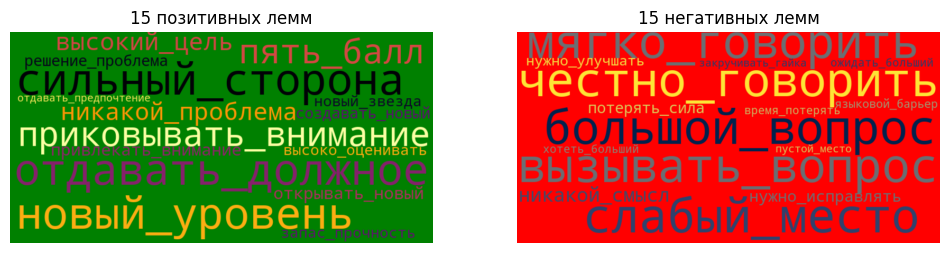

In [27]:
clouds(top_15_pos_ru, top_15_neg_ru)

Просчитаем относительные частоты позитивных, негативных и нейтральных слов:

In [28]:
print(f'Относительная частота позитивных слов/n-gramm: {pos_count/len(lemmas)}')
print(f'Относительная частота негативных слов/n-gramm: {neg_count/len(lemmas)}')
print(f'Относительная частота нейтральных слов/n-gramm: {neutral_count/len(lemmas)}')

Относительная частота позитивных слов/n-gramm: 0.0008083456762131963
Относительная частота негативных слов/n-gramm: 0.0006309039424102995
Относительная частота нейтральных слов/n-gramm: 0.0006037947886348569


Теперь проделаем аналогичный  анализ англоязычного корпуса.


In [29]:
with open("nhl_articles_nytimes.txt", "r", encoding='utf-8') as f:
    text_nhl = f.read()

In [30]:
stop_words_eng = stopwords.words('english')

In [31]:
text_nhl=text_nhl.lower()
tokens_nhl = word_tokenize(text_nhl) #делим на токены
text_no_punkt = [word for word in tokens_nhl if word[0].isalpha()]
tokens_clean = [word for word in text_no_punkt if word not in stop_words_eng]
print (tokens_clean[:10])

['six', 'weeks', 'march', 'trade', 'deadline', 'market', 'still', 'taking', 'shape', 'activity']


In [32]:
lemmatizer = WordNetLemmatizer()

In [33]:
def pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Прилагательное
    elif tag.startswith('V'):
        return wordnet.VERB  # Глагол
    elif tag.startswith('N'):
        return wordnet.NOUN  # Существительное
    elif tag.startswith('R'):
        return wordnet.ADV  # Наречие
    else:
        return wordnet.NOUN

In [34]:
tagged_tokens = nltk.pos_tag(tokens_clean)

In [35]:
lemmatized_tokens = []
for token, tag in tagged_tokens:
    wordnet_pos = pos(tag) 
    lemmatized_token = lemmatizer.lemmatize(token, wordnet_pos)  # лемматизируем слово
    lemmatized_tokens.append(lemmatized_token)
print (lemmatized_tokens[:10])
print (len(lemmatized_tokens))    

['six', 'week', 'march', 'trade', 'deadline', 'market', 'still', 'take', 'shape', 'activity']
910799


In [36]:
word_freq = FreqDist(lemmatized_tokens) #создаем частотный словарь
top_1000=word_freq.most_common(1000)
print (top_1000[:10])

[('team', 9700), ('season', 9052), ('game', 8512), ('play', 8470), ('year', 8120), ('player', 7803), ('get', 7455), ('go', 6348), ('nhl', 5963), ('one', 5942)]


In [37]:
words_1000 = []
for i in top_1000:
    word = i[0]  
    words_1000.append(word)

In [38]:
bigrams_nhl = list(nltk.bigrams(lemmatized_tokens))
trigrams_nhl = list(nltk.trigrams(lemmatized_tokens))
print(bigrams_nhl[:15])
print(trigrams_nhl[:15])

[('six', 'week'), ('week', 'march'), ('march', 'trade'), ('trade', 'deadline'), ('deadline', 'market'), ('market', 'still'), ('still', 'take'), ('take', 'shape'), ('shape', 'activity'), ('activity', 'slow'), ('slow', 'flurry'), ('flurry', 'move'), ('move', 'earlier'), ('earlier', 'season'), ('season', 'still')]
[('six', 'week', 'march'), ('week', 'march', 'trade'), ('march', 'trade', 'deadline'), ('trade', 'deadline', 'market'), ('deadline', 'market', 'still'), ('market', 'still', 'take'), ('still', 'take', 'shape'), ('take', 'shape', 'activity'), ('shape', 'activity', 'slow'), ('activity', 'slow', 'flurry'), ('slow', 'flurry', 'move'), ('flurry', 'move', 'earlier'), ('move', 'earlier', 'season'), ('earlier', 'season', 'still'), ('season', 'still', 'unclear')]


Соберем списки позитивных, негативных и нейтральных слов на английском язые, используя словарь SentiWordNet из NLTK.

In [39]:
pos_words_eng = []
neg_words_eng = []
neutral_words_eng = []

for word in lemmatized_tokens:
    # Получаем все синонимы для слова
    synonyms = wn.synsets(word)
    
    # Проверяем оценки тональности для каждого синонима
    for syn in synonyms:
        senti_synset = swn.senti_synset(syn.name())
        pos_score = senti_synset.pos_score()
        neg_score = senti_synset.neg_score()
        obj_score = senti_synset.obj_score()
        
        # Определяем тональность
        if pos_score > neg_score and pos_score > obj_score:
            pos_words_eng.append(word)
            break
        elif neg_score > pos_score and neg_score > obj_score:
            neg_words_eng.append(word)
            break
        else:
            neutral_words_eng.append(word)
            break
pos_words_eng = set(pos_words_eng)
neg_words_eng = set(neg_words_eng)
neutral_words_eng = set(neutral_words_eng)

Дополним списки эмоционально-окрашенных слов:

In [40]:
extra_pos_words_eng = "goal, win, victory, champion, unstoppable, dominance, fast, strong, skillful, brilliant, masterful, sharp, resilient, clutch, spectacular, comeback, shutout, game-winner, perfect, tactical, disciplined, solid, power play, breakaway goal, perfect shot, brilliant assist, clutch performance, dominant game, masterful control, resilient defense, solid goaltending, tactical strategy, game winning goal, perfect power play, unbelievable goalie save, flawless team coordination, brilliant puck control, masterful offensive setup, tactical defensive play"
extra_neg_words_eng = "loss, defeat, failure, collapse, weak, slow, turnover, mistake, sloppy, breakdown, poor, disaster, nervous, unstable, miss, flop, outplayed, penalty, unfocused, injury, fatigue, frustration, error, defensive breakdown, turnover disaster, weak coverage, missed chance, poor execution, nervous start, unforced error, penalty trouble, lack coordination, unstable defense, defense fell apart, critical mistake made, goalie misjudged shot, missed game opportunity, frustrating turnover sequence, poor positioning cost, collapsed under pressure"


In [41]:
pos_words_eng.update(extra_pos_words_eng)
neg_words_eng.update(extra_neg_words_eng)

In [42]:
pos_count_nhl, neg_count_nhl, neutral_count_nhl, positive_lemm, negative_lemm, neutral_lemm = count(lemmatized_tokens, pos_words_eng, neg_words_eng, neutral_words_eng, bigrams_nhl, trigrams_nhl)

print(f"Положительных: {pos_count_nhl}")
print(f"Отрицательных: {neg_count_nhl}")
print(f"Нейтральных: {neutral_count_nhl}")

Положительных: 19367
Отрицательных: 15848
Нейтральных: 744992


In [43]:
top_15_pos_en=top_15(positive_lemm)
top_15_neg_en=top_15(negative_lemm)
top_15_neutral_en=top_15(neutral_lemm)
print (f"Топ 15 положительных лемм: {top_15_pos_en}")
print (f"Топ 15 отрицательных лемм: {top_15_neg_en}")
print (f"Топ 15 нейтральных лемм: {top_15_neutral_en}")

Топ 15 положительных лемм: [('really', 1962), ('know', 1784), ('find', 1262), ('add', 1191), ('u', 706), ('different', 699), ('pretty', 680), ('important', 534), ('love', 522), ('easy', 515), ('excellent', 431), ('healthy', 360), ('wonder', 294), ('plus', 283), ('decent', 242)]
Топ 15 отрицательных лемм: [('hard', 1179), ('injury', 1099), ('bad', 1073), ('might', 1071), ('never', 901), ('sure', 762), ('despite', 581), ('quite', 447), ('difficult', 384), ('however', 291), ('problem', 287), ('smart', 268), ('wrong', 253), ('dangerous', 204), ('difference', 204)]
Топ 15 нейтральных лемм: [('team', 9700), ('season', 9052), ('game', 8512), ('play', 8470), ('year', 8120), ('player', 7803), ('get', 7455), ('go', 6348), ('one', 5942), ('say', 5574), ('make', 5519), ('last', 5419), ('like', 4622), ('good', 4167), ('goal', 4035)]


In [44]:
top_15_pos_en = ' '.join(word[0] for word in top_15_pos_en)
top_15_neg_en = ' '.join(word[0] for word in top_15_neg_en)

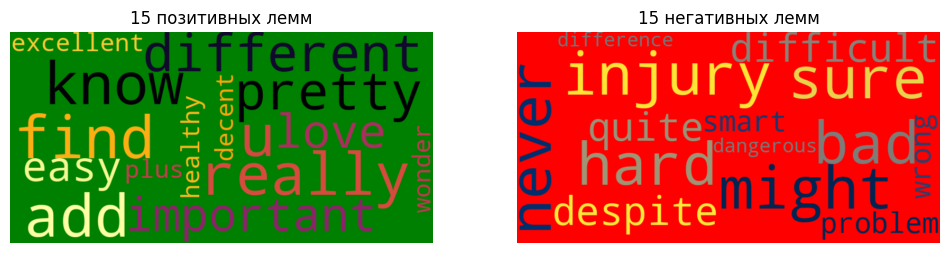

In [45]:
clouds(top_15_pos_en, top_15_neg_en)

In [46]:
pos_count_nhl_1000, neg_count_nhl_1000, neutral_count_nhl_1000, positive_lemm, negative_lemm, neutral_lemm = count(words_1000, pos_words_eng, neg_words_eng, neutral_words_eng, bigrams_nhl, trigrams_nhl)

print(f"Положительных: {pos_count_nhl_1000}")
print(f"Отрицательных: {neg_count_nhl_1000}")
print(f"Нейтральных: {neutral_count_nhl_1000}")

Положительных: 27
Отрицательных: 22
Нейтральных: 844


In [47]:
print(f'Относительная частота позитивных слов/n-gramm: {pos_count_nhl/len(lemmatized_tokens)}')
print(f'Относительная частота негативных слов/n-gramm: {neg_count_nhl/len(lemmatized_tokens)}')
print(f'Относительная частота нейтральных слов/n-gramm: {neutral_count_nhl/len(lemmatized_tokens)}')

Относительная частота позитивных слов/n-gramm: 0.02126374754473819
Относительная частота негативных слов/n-gramm: 0.017400106939072176
Относительная частота нейтральных слов/n-gramm: 0.8179543455800896


In [48]:
labels = ["Позитивные", "Негативные", "Нейтральные"]
eng = [19367, 15848, 744992]
rus = [25248, 12451, 1689]
colors = ["green", "red", "gray"]

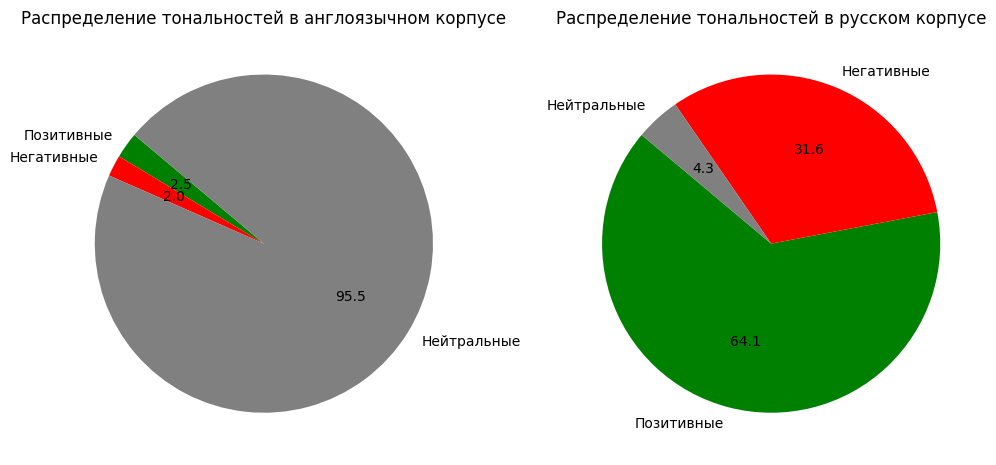

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(eng, labels=labels, autopct="%1.1f", colors=colors, startangle=140)
axes[0].set_title("Распределение тональностей в англоязычном корпусе")

axes[1].pie(rus, labels=labels, autopct="%1.1f", colors=colors, startangle=140)
axes[1].set_title("Распределение тональностей в русском корпусе")

plt.show()